<a href="https://colab.research.google.com/github/Fethbita/TalTech_ITI8730_Data_Mining_Final_Project/blob/main/Final_Project_with_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Mount drive to colab
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#@title Imports
import gzip
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
# https://stackoverflow.com/a/6252494/6077951
from scipy.stats import mode

from sklearn.cluster import KMeans

In [3]:
#@title Function for loading the dataset
def load_dataset(images_file, labels_file, mapping_file):
    with gzip.open(images_file, 'r') as infile:
        infile.read(16)
        images = infile.read()
    images = np.frombuffer(images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(-1, 28 * 28, 1).squeeze()
    images = torch.from_numpy(images).cuda()
    
    with gzip.open(labels_file, 'r') as infile:
        infile.read(8)
        labels = infile.read()
    labels = np.frombuffer(labels, dtype=np.uint8).astype(np.int64)

    with open(mapping_file, 'r') as infile:
        mapping = infile.read().splitlines()
    mapping = [int(i.split()[1]) for i in mapping]
    mapping = np.array(mapping)
    print(list(map(chr,mapping)))

    labels = mapping[labels]
    labels = torch.from_numpy(labels).cuda()

    return images, labels

In [4]:
#@title Function to print the images
def plot_data(X, Y, columns, rows, pred=None, labels_as_cluster=False):
    fig = plt.figure(figsize=(15, 15))
    els = min(columns * rows, len(X))
    for i in range(els):
        img = np.transpose(np.asarray((255 - X[i].cpu()).reshape(28, 28)))
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img, cmap="gray")
        ax = plt.gca()
        ax.axis('off')
        label = str(Y[i]) if labels_as_cluster else chr(Y[i])
        ax.text(0, 0, "label: " + label, size=15, ha="left", va="bottom", transform=ax.transAxes)
        if pred is not None:
            label = str(pred[i]) if labels_as_cluster else chr(pred[i])
            ax.text(1, 0, "pred: " + label, size=15, ha="right", va="bottom", transform=ax.transAxes)
    plt.show()

In [5]:
dirname = "/content/gdrive/My Drive/TalTech/Data Mining/emnist/"
X_train, Y_train = load_dataset(dirname + 'emnist-balanced-train-images-idx3-ubyte.gz',
                                       dirname + 'emnist-balanced-train-labels-idx1-ubyte.gz',
                                       dirname + 'emnist-balanced-mapping.txt')

X_test, Y_test = load_dataset(dirname + 'emnist-balanced-test-images-idx3-ubyte.gz',
                                       dirname + 'emnist-balanced-test-labels-idx1-ubyte.gz',
                                       dirname + 'emnist-balanced-mapping.txt')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


In [6]:
print(X_train.shape)
print(X_test.shape)

torch.Size([112800, 784])
torch.Size([18800, 784])


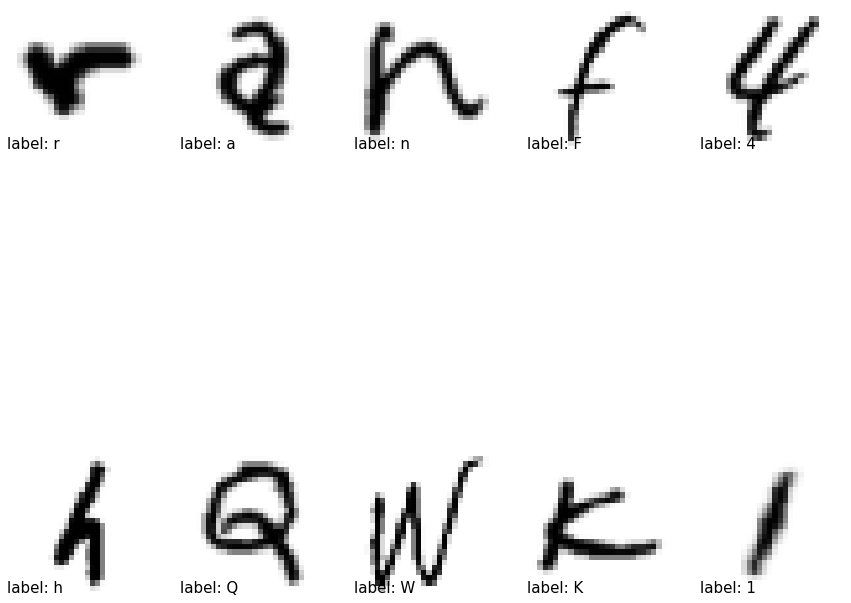

In [7]:
plot_data(X_train, Y_train, 5, 2)

In [8]:
#@title Function of k-nearest neighbors (k-NN)
def knn(dataset, labels, images, k, batch_size):
    if images.dim() != 2:
        raise ValueError("[!] images should have 2 dimensions. Index with X_test[:1] instead of X_test[0]")
    nm_of_images = images.shape[0]
    preds = ()
    for i in range(0, nm_of_images, batch_size):
        batch = images[i:i+batch_size]
        batch = batch.reshape((-1, 28*28))
        dists = torch.cdist(dataset, batch)
        topk_val, topk_idx = dists.topk(k, dim=0, largest=False)
        batch_pred, _ = torch.mode(labels[topk_idx], dim=0)
        preds += (batch_pred,)
    return torch.cat(preds, dim=0)

With k=3, 14667 correct guesses out of 18800, 78.02%, 47 classes

Some wrong classified examples:


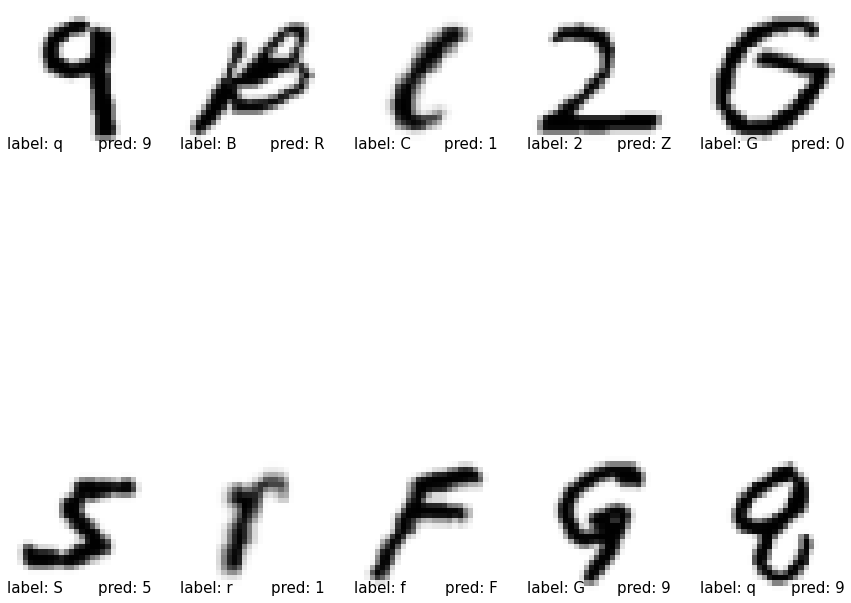

In [9]:
#@title k-nearest neighbors (k-NN) one time run
k = 3 #@param {type:"slider", min:1, max:10, step:1}
batch_size = 10000 #@param {type:"slider", min:0, max:100000, step:1}

pred = knn(X_train, Y_train, X_test, k, batch_size)
number_of_correct = torch.sum(pred == Y_test)

print("With k={}, {} correct guesses out of {}, {:.2f}%, {} classes".format(k, number_of_correct,
                                                                len(Y_test),
                                                                number_of_correct / len(Y_test) * 100,
                                                                len(torch.unique(Y_test))))
print("\nSome wrong classified examples:")
plot_data(X_test[pred!=Y_test], Y_test[pred!=Y_test], 5, 2, pred[pred!=Y_test])
del pred
del number_of_correct

In [10]:
#@title k-nearest neighbors (k-NN) tests
for k in range(1, 8):
    pred = knn(X_train, Y_train, X_test, k, 10000)
    number_of_correct = torch.sum(pred == Y_test)
    print("With k={}, {} correct guesses out of {}, {:.2f}%, {} classes".format(k, number_of_correct,
                                                                    len(Y_test),
                                                                    number_of_correct / len(Y_test) * 100,
                                                                    len(torch.unique(Y_test))))
    del pred
    del number_of_correct

With k=1, 14452 correct guesses out of 18800, 76.87%, 47 classes
With k=2, 14300 correct guesses out of 18800, 76.06%, 47 classes
With k=3, 14667 correct guesses out of 18800, 78.02%, 47 classes
With k=4, 14723 correct guesses out of 18800, 78.31%, 47 classes
With k=5, 14751 correct guesses out of 18800, 78.46%, 47 classes
With k=6, 14715 correct guesses out of 18800, 78.27%, 47 classes
With k=7, 14739 correct guesses out of 18800, 78.40%, 47 classes


In [11]:
#@title Function of LVQ3 train
# Inspired by http://ccy.dd.ncu.edu.tw/~chen/course/Neural/ch4/index.htm
def LVQ3_train(dataset, labels, ppc, learning_rate, window, epsilon, epoch, lr_ss=0):
    """
    ppc is how many prototypes to create per class in the codebook.
    lr_ss is how much to update learning rate each epoch, default=0
    """
    X_codebook = []
    Y_codebook = []
    to_remove_indices = []
    for i in torch.unique(labels):
        X_codebook.append(dataset[labels == i][:ppc])
        Y_codebook.extend([i] * ppc)
        to_remove_indices.append(torch.squeeze(torch.nonzero(labels == i)[:ppc]))
    X_codebook = torch.cat(X_codebook).cuda()
    Y_codebook = torch.Tensor(Y_codebook).cuda()
    to_remove_indices = torch.cat(to_remove_indices).cpu().numpy()
    dataset = torch.from_numpy(np.delete(dataset.cpu().numpy(), to_remove_indices, 0)).cuda() # Remove codebook elements
    labels = torch.from_numpy(np.delete(labels.cpu().numpy(), to_remove_indices, 0)).cuda() # Remove codebook elements
    del to_remove_indices

    s = (1 - window) * (1 + window)
    for _ in range(epoch):
        for i in range(len(labels)):
            dists = torch.cdist(dataset[i:i+1], X_codebook)
            topk_val, topk_idx = dists.topk(2, dim=1, largest=False) # Find closest 2 codebook elements for training sample
            dist = torch.min(topk_val[0][0] / topk_val[0][1], topk_val[0][1] / topk_val[0][1])
            if dist > s: # learning condition
                # If closest belongs to the class as the training sample and the second closest does not
                if Y_codebook[topk_idx[0][0]] == labels[i] and Y_codebook[topk_idx[0][1]] != labels[i]:
                    X_codebook[topk_idx[0][0]] += learning_rate * (dataset[i] - X_codebook[topk_idx[0][0]])
                    X_codebook[topk_idx[0][1]] -= learning_rate * (dataset[i] - X_codebook[topk_idx[0][1]])
                # If closest doesn't belong to the class as the training sample and the second closest does
                elif Y_codebook[topk_idx[0][0]] != labels[i] and Y_codebook[topk_idx[0][1]] == labels[i]:
                    X_codebook[topk_idx[0][0]] -= learning_rate * (dataset[i] - X_codebook[topk_idx[0][0]])
                    X_codebook[topk_idx[0][1]] += learning_rate * (dataset[i] - X_codebook[topk_idx[0][1]])
                # Both closest belong to the same class as the training sample
                elif Y_codebook[topk_idx[0][0]] == labels[i] and Y_codebook[topk_idx[0][1]] == labels[i]:
                    X_codebook[topk_idx[0][0]] += learning_rate * epsilon * (dataset[i] - X_codebook[topk_idx[0][0]])
                    X_codebook[topk_idx[0][1]] += learning_rate * epsilon * (dataset[i] - X_codebook[topk_idx[0][1]])
            # Both closest don't belong to the class then update the closest
            else:
                X_codebook[topk_idx[0][0]] -= learning_rate * (dataset[i] - X_codebook[topk_idx[0][0]])
        learning_rate += lr_ss
    return X_codebook, Y_codebook

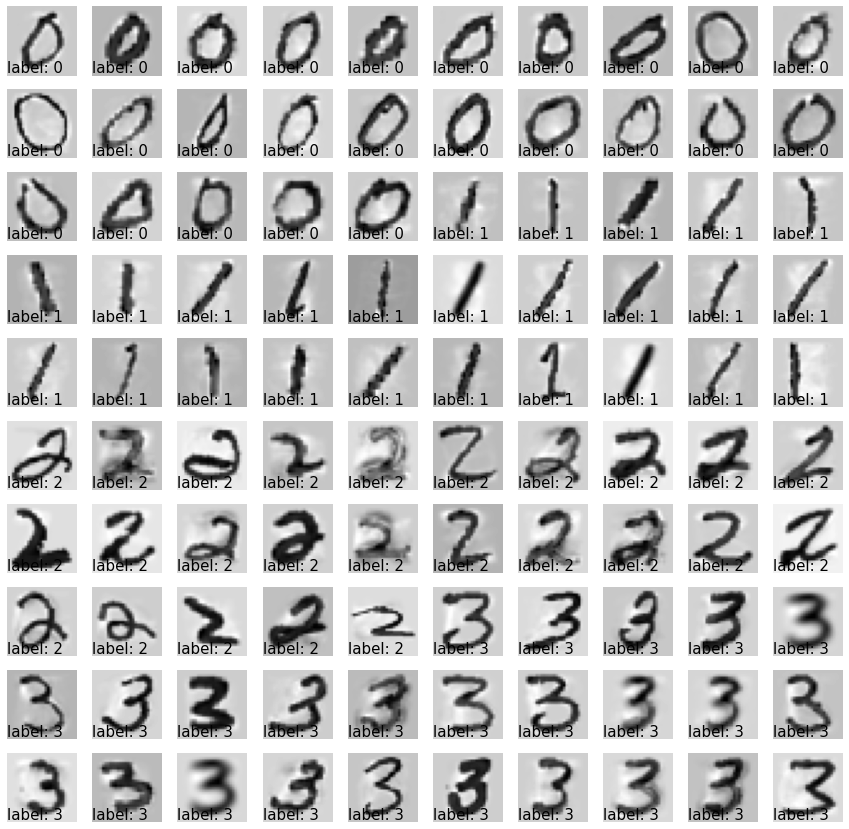

In [12]:
#@title Train LVQ3 codebooks and show some codebook prototypes
X_codebook, Y_codebook = LVQ3_train(X_train, Y_train, 25, 0.01, 0.25, 0.3, 10, -0.001)
plot_data(X_codebook, Y_codebook, 10, 10)

With k=1, 11556 correct guesses out of 18800, 61.47%, 47 classes

Some wrong classified examples:


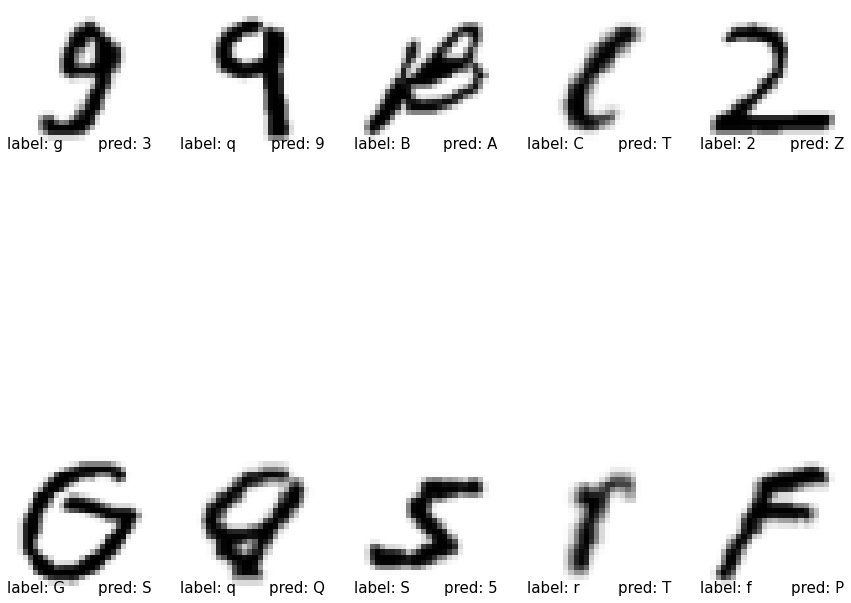

In [13]:
#@title LVQ3, predict the test data and show some wrong predictions 
k = 1 #@param {type:"slider", min:1, max:10, step:1}
batch_size = 10000 #@param {type:"slider", min:0, max:100000, step:1}
pred = knn(X_codebook, Y_codebook, X_test, k, batch_size)
number_of_correct = torch.sum(pred == Y_test)

print("With k={}, {} correct guesses out of {}, {:.2f}%, {} classes".format(k, number_of_correct,
                                                                len(Y_test),
                                                                number_of_correct / len(Y_test) * 100,
                                                                len(torch.unique(Y_test))))
print("\nSome wrong classified examples:")
plot_data(X_test[pred!=Y_test], Y_test[pred!=Y_test], 5, 2, pred[pred!=Y_test])
del pred
del number_of_correct

In [14]:
#@title Train kmeans cluster centers with default values
kmeans = KMeans(n_clusters=47, n_init=2, max_iter=1000, verbose=0).fit(X_train.cpu().numpy())

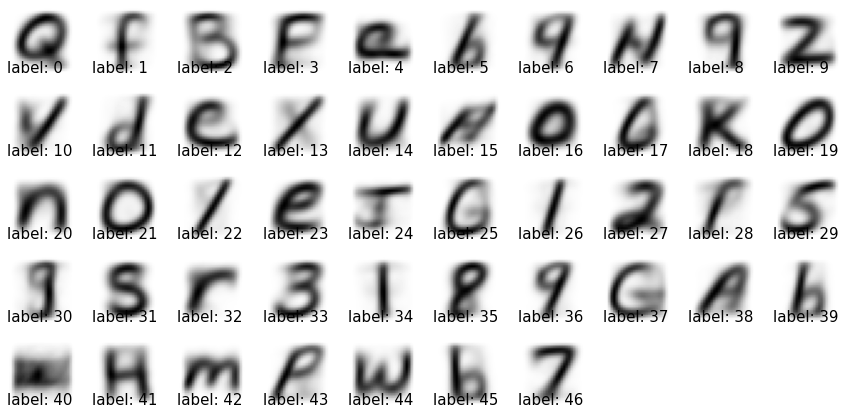

In [15]:
#@title Show the cluster centers
plot_data(torch.from_numpy(kmeans.cluster_centers_), list(range(47)), 10, 10, labels_as_cluster=True)

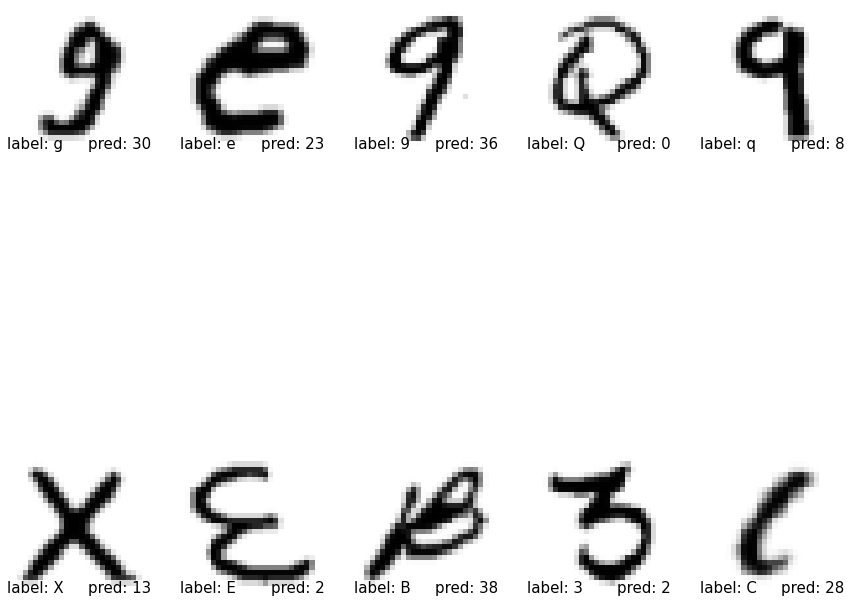

In [16]:
#@title Predict some test data and show the labels & predictions
preds = kmeans.predict(X_test[0:10].cpu().numpy())
plot_data(X_test[0:10], list(map(chr, Y_test[0:10].cpu().numpy())), 5, 2, preds, labels_as_cluster=True)